In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import DatasetFolder
from tqdm import tqdm
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

2.0.0+cu117


In [2]:
#from dataset import TerrainDataset
from datasetIMU import TerrainDatasetIMU
#from pointnet import PointNet
#from pointnetCurv import PointNetCurv

dataset = TerrainDatasetIMU(root='/home/atas/RESEARCH/traversablity_estimation_net/data_imu',train=True)


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

from torch_geometric.loader import DataLoader
from pointnet_curv import PointnetCurv

train_dataset =  TerrainDatasetIMU(root='/home/atas/RESEARCH/traversablity_estimation_net/data_imu', train=True )
test_dataset = TerrainDatasetIMU(root='/home/atas/RESEARCH/traversablity_estimation_net/data_imu', train=False)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1)

model = PointnetCurv()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#criterion = torch.nn.MSELoss()  # Mean Squared Error Loss Function
criterion = torch.nn.L1Loss()  # Mean Absolute Error (L1 Loss Function)

def train(model, optimizer, loader):
    model.train()
    total_loss = 0.0
    for data in loader:
        optimizer.zero_grad()                   # Clear gradients.
        # reshape to have 1 at the end
        data.pos = data.pos.reshape((data.pos.shape[0], data.pos.shape[1], 1))
        
        
        logits = model(data.pos, data.face, data.batch)                # Forward pass.
        loss = criterion(logits, data.y)        # Loss computation.
        loss.backward()                         # Backward pass.
        optimizer.step()                        # Update model parameters.
        total_loss += loss.item()

    return total_loss


@torch.no_grad()
def test(model, loader):
    model.eval()

    error = 0.0
    for data in loader:
        data.pos = data.pos.reshape((data.pos.shape[0], data.pos.shape[1], 1))
        pred = model(data.pos, data.face, data.batch)
        error += torch.pow((pred - data.y), 2).sum().item()
    
    # convert error to percentage accuracy
    return error

<IPython.core.display.Javascript object>

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Epoch: 01, Loss: 148.8317, MSE: 3.2247
Epoch: 02, Loss: 117.4874, MSE: 4.6385
Epoch: 03, Loss: 102.6347, MSE: 2.6222
Epoch: 04, Loss: 102.9209, MSE: 2.7281
Epoch: 05, Loss: 96.0678, MSE: 2.8150
Epoch: 06, Loss: 93.5819, MSE: 2.9292
Epoch: 07, Loss: 92.4354, MSE: 2.5871
Epoch: 08, Loss: 93.5125, MSE: 1.7355
Epoch: 09, Loss: 91.9071, MSE: 2.4578
Epoch: 10, Loss: 90.0023, MSE: 1.8959
Epoch: 11, Loss: 87.4532, MSE: 2.6468
Epoch: 12, Loss: 86.5907, MSE: 2.7751
Epoch: 13, Loss: 85.7881, MSE: 3.1977
Epoch: 14, Loss: 89.8392, MSE: 3.0513
Epoch: 15, Loss: 86.9248, MSE: 2.9200
Epoch: 16, Loss: 84.9858, MSE: 2.5745
Epoch: 17, Loss: 87.2092, MSE: 2.1831
Epoch: 18, Loss: 87.4412, MSE: 2.4599
Epoch: 19, Loss: 82.9596, MSE: 2.8919
Epoch: 20, Loss: 81.2845, MSE: 2.8808
Epoch: 21, Loss: 81.1834, MSE: 3.1532
Epoch: 22, Loss: 80.2563, MSE: 2.2587
Epoch: 23, Loss: 81.5651, MSE: 2.6000
Epoch: 24, Loss: 79.3639, MSE: 3.6497
Epoch: 25, Loss: 77.5942, MSE: 3.5820
Epoch: 26, Loss: 79.2978, MSE: 3.0070
Epoch: 2

Text(0.5, 0, 'epochs')

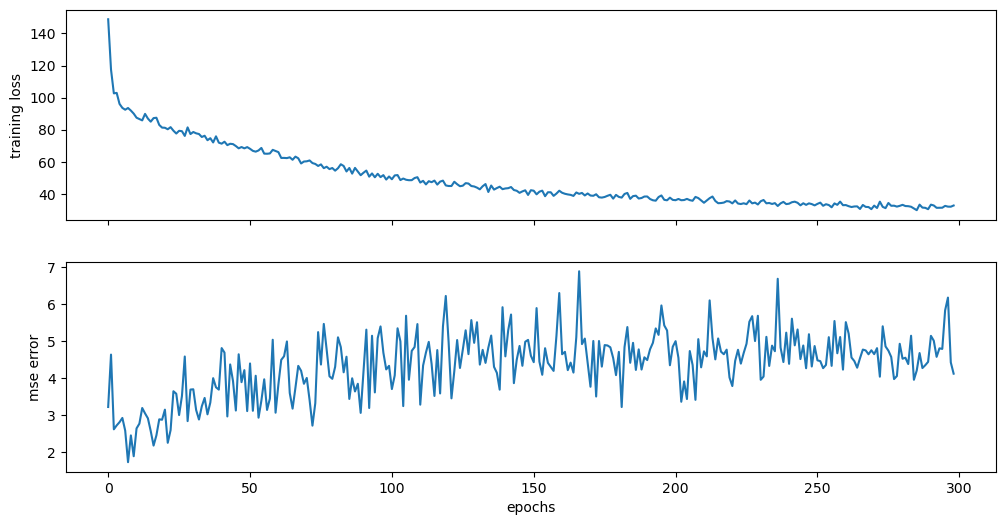

In [4]:
train_loss=[]
test_mse=[]

# Save every 10th epoch model.
for epoch in range(1, 300):
    loss = train(model, optimizer, train_loader)
    mse = test(model, test_loader)
    if epoch % 50 == 0:
        torch.save(model.state_dict(), f'epoch_{epoch}.pt')
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, MSE: {mse:.4f}')
    train_loss.append(loss)
    test_mse.append(mse)
    
fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 6), sharex=True)
ax1.plot(train_loss)
ax1.set_ylabel("training loss")
ax2.plot(test_mse)
ax2.set_ylabel("mse error")
ax2.set_xlabel("epochs")    

In [7]:
visual_test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Load the model
# print curdir()
print(os.getcwd())

net = PointnetCurv()
net.load_state_dict(torch.load('/home/atas/RESEARCH/traversablity_estimation_net/weights/epoch_250.pt'))
net.eval()

error = 0.0
for data in visual_test_loader:
 
    inputs, labels = data.pos, data.y
    inputs = inputs.reshape((inputs.shape[0], inputs.shape[1], 1))
    outputs = net(inputs, data.face, data.batch)
    
    error += torch.pow((outputs - data.y), 2).sum().item()
    outputs = outputs.cpu().detach().numpy()
    labels = labels.cpu().detach().numpy()

error = error / len(visual_test_loader)
print("MSE: " + str(error))    


SyntaxError: invalid syntax. Perhaps you forgot a comma? (2331078295.py, line 16)